In [1]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D ,SeparableConv2D, MaxPooling2D , Input , GlobalAveragePooling2D ,AveragePooling2D, Dense , Dropout ,Activation, Flatten , BatchNormalization, add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from numpy import loadtxt
from sklearn.metrics import f1_score, recall_score, confusion_matrix, roc_auc_score, average_precision_score
from sklearn.metrics import roc_curve, precision_recall_curve, auc
from sklearn.model_selection import train_test_split
debug = True

combined_dataset = pd.read_csv("/kaggle/input/combined-dataset/combinedBalancedDataset.csv", header=None, delimiter=',')
print(combined_dataset)
all_scores = {}
batch_size = 16
epochs = 30

2024-02-04 07:42:08.018917: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-04 07:42:08.019049: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-04 07:42:08.172359: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


        0   1   2   3   4    5   6    7    8   9   ...  20  21   22  23  24  \
0        3   8  34  40  83   34  71    3    2  55  ...   3   2   38  26   3   
1       19  27  36   6  23    8   1   63   40  38  ...  63  12   47  14  16   
2       16  47  98   9  50    7  17  112   50  46  ...  16  17   44  33  55   
3       30  84   5  23  43   33   3   39  121  85  ...   3  32   59  63  55   
4       19  20  61  14   4    8   4   76   14  44  ...  76  14   52  21   6   
...     ..  ..  ..  ..  ..  ...  ..  ...  ...  ..  ...  ..  ..  ...  ..  ..   
213563  35  79  28  25  45  126   5   43  102  21  ...   4  45   82  12  61   
213564  15  32  37  12   2   12   1   64   23  46  ...  64   9   46  12  47   
213565  90  66   8  62  10   84  32   60   45  97  ...  10  20   22  75  50   
213566  16  42  98   9  57    6  17  112   49  46  ...  78  48  110  13  60   
213567  20  21  28   9  20   40  19   16   42  22  ...  69  33   67  47  49   

        25  26  27  28  29  
0       56   1   1   0

In [2]:
x_ = combined_dataset.drop(columns=[26, 27, 28, 29])
y_ = combined_dataset.filter([26, 27, 28, 29])
x_train, x_test, y_train, y_test = train_test_split(x_, y_, test_size=0.2, random_state=42)

# Reshape input data
x_train = x_train.values.reshape(-1, x_train.shape[1], 1, 1)
x_test = x_test.values.reshape(-1, x_test.shape[1], 1, 1)

if debug:
    print('shape of x_train after reshaping', x_train.shape)
    print('shape of x_test after reshaping', x_test.shape)

#determine batch size
batch_size = min(x_train.shape[0] / 10, batch_size)
if debug:
    print('batch size: ' + str(batch_size))

# Modify input shape accordingly
input_shape = (x_train.shape[1], 1, 1)
# Create the input layer
inputs = Input(shape=input_shape)

# Entry Flow
x = Conv2D(32, (3, 3), strides=(2, 2), padding='same')(inputs)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(64, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

previous_block_activation = x
for size in [128, 256, 728]:
    x = Activation('relu')(x)
    x = Conv2D(size, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)

    x = Activation('relu')(x)
    x = Conv2D(size, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    residual = Conv2D(size, (1, 1), strides=(2, 2), padding='same')(previous_block_activation)
    x = add([x, residual])
    previous_block_activation = x

def middle_flow(x, num_blocks=8):
    previous_block_activation = x

    for _ in range(num_blocks):
        x = Activation('relu')(x)
        x = SeparableConv2D(728, 3, padding='same')(x)
        x = BatchNormalization()(x)

        x = Activation('relu')(x)
        x = SeparableConv2D(728, 3, padding='same')(x)
        x = BatchNormalization()(x)

        x = add([x, previous_block_activation])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    return x

def exit_flow(x, num_classes):
    previous_block_activation = x

    x = Activation('relu')(x)
    x = SeparableConv2D(728, 3, padding='same')(x)
    x = BatchNormalization()(x)

    x = Activation('relu')(x)
    x = SeparableConv2D(1024, 3, padding='same')(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D(3, strides=2, padding='same')(x)

    residual = Conv2D(  # Project residual
        1024, 1, strides=2, padding='same')(previous_block_activation)
    x = add([x, residual])  # Add back residual

    x = SeparableConv2D(1536, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = SeparableConv2D(2048, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = GlobalAveragePooling2D()(x)

    if num_classes == 1:
        activation = 'sigmoid'
    else:
        activation = 'softmax'

    return Dense(num_classes, activation=activation)(x)



# Define the number of classes based on your task
num_classes = 4  # Adjust this according to your task

# Final Dense Layer
x = GlobalAveragePooling2D()(x)
if num_classes == 1:
    activation = 'sigmoid'
else:
    activation = 'softmax'
outputs = Dense(num_classes, activation=activation)(x)

# Create the model
model = Model(inputs, outputs)

# Compile the model with an appropriate optimizer, loss function, and metrics
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size)

y_pred = model.predict(x_test)
y_pred = (y_pred > 0.5).astype(int)

shape of x_train after reshaping (170854, 26, 1, 1)
shape of x_test after reshaping (42714, 26, 1, 1)
batch size: 16
Train on 170854 samples
Epoch 1/30
170854/170854 [==============================] - 103s 602us/sample - loss: 0.6460 - acc: 0.5348
Epoch 2/30
170854/170854 [==============================] - 99s 579us/sample - loss: 0.5382 - acc: 0.5955
Epoch 3/30
170854/170854 [==============================] - 99s 579us/sample - loss: 0.4588 - acc: 0.6286
Epoch 4/30
170854/170854 [==============================] - 99s 579us/sample - loss: 0.4003 - acc: 0.6482
Epoch 5/30
170854/170854 [==============================] - 99s 579us/sample - loss: 0.3563 - acc: 0.6605
Epoch 6/30
170854/170854 [==============================] - 99s 580us/sample - loss: 0.3205 - acc: 0.6703
Epoch 7/30
170854/170854 [==============================] - 99s 579us/sample - loss: 0.2923 - acc: 0.6774
Epoch 8/30
170854/170854 [==============================] - 99s 579us/sample - loss: 0.2690 - acc: 0.6820
Epoch 9/30

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [3]:
y_test

,26,27,28,29
35604,0,0,1,1
113980,1,0,1,0
27131,1,1,0,0
146982,0,0,1,1
124519,1,1,1,1
...,...,...,...,...
180768,0,1,1,0
14420,0,1,1,0
1774,1,0,0,0
178657,1,0,0,1


In [ ]:
y_pred

array([[0, 1, 0, 0],
       [1, 0, 0, 0],
       [0, 1, 0, 0],
       ...,
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 1, 0]])

In [ ]:
y_test = np.array(y_test)
y_test = y_test.flatten()
y_pred = y_pred.flatten()

In [ ]:
y_test

array([0, 0, 1, ..., 0, 1, 0])

In [ ]:
y_pred

array([0, 1, 0, ..., 0, 1, 0])

Confusion Matrix: [[81072  4020]
 [48446 37318]]


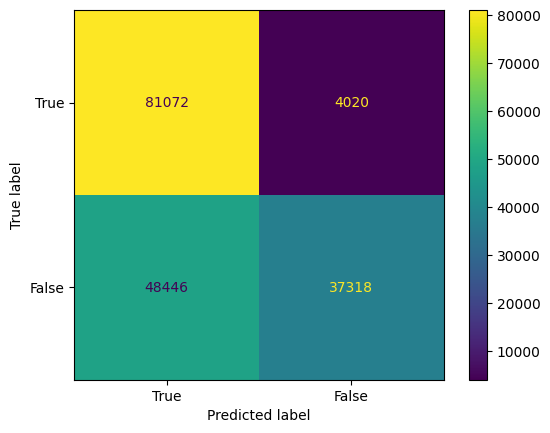

FPR: 0.04724298406430687 TPR: 0.4351242945758127


In [ ]:
from sklearn import metrics
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:",cm)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [True, False])
cm_display.plot()
plt.savefig('/kaggle/working/xception_cm.png')
plt.show()

fpr_cm = cm[0, 1] / (cm[0, 1] + cm[0, 0])
tpr_cm = cm[1, 1] / (cm[1, 1] + cm[1, 0])

print("FPR:", fpr_cm, "TPR:", tpr_cm)

ROC: 0.693940655255753


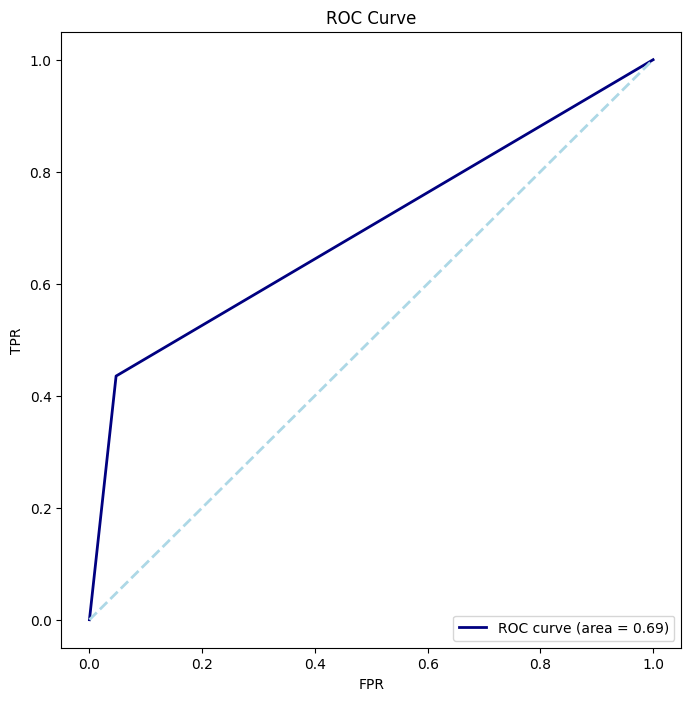

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print("ROC:",roc_auc)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='navy', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='lightblue', lw=2, linestyle='--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.savefig('/kaggle/working/xception_roc.png')
plt.show()

PRC: 0.8107129644793543


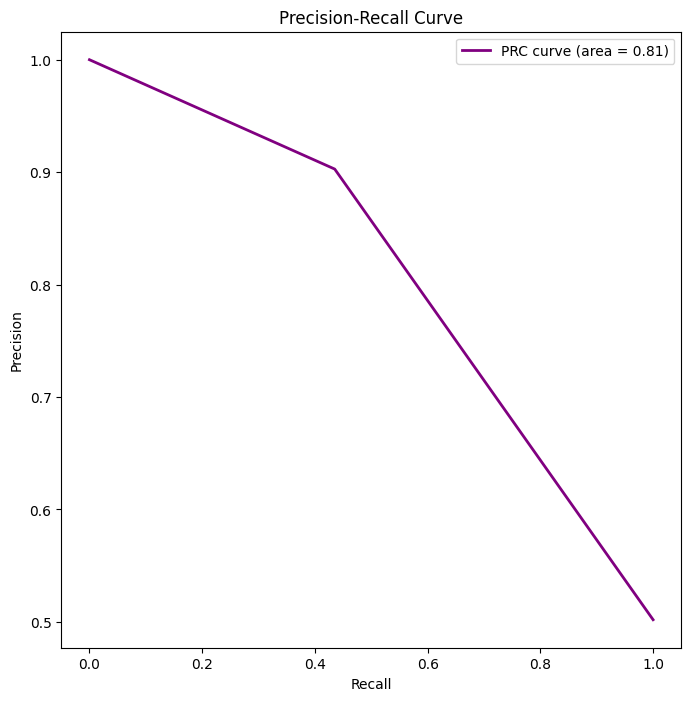

In [ ]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
prc_auc = auc(recall, precision)
print("PRC:",prc_auc)

plt.figure(figsize=(8, 8))
plt.plot(recall, precision, color='purple', lw=2, label='PRC curve (area = {:.2f})'.format(prc_auc))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='upper right')
plt.savefig('/kaggle/working/xception_prc.png')
plt.show()

In [ ]:
f1_score_value = f1_score(y_test, y_pred, average='macro')
recall_score_value = recall_score(y_test, y_pred, average='macro')

print("F1 score:",f1_score_value,"recall score:", recall_score_value)

F1 score: 0.6713710262392832 recall score: 0.693940655255753


In [ ]:
all_scores= {
    'F1 Score': f1_score_value,
    'Recall': recall_score_value,
    'FPR': fpr_cm,
    'TPR': tpr_cm,
    'ROC AUC': roc_auc,
    'PRC AUC': prc_auc
    }
print('F1 Score:', f1_score_value)
print('Recall:', recall_score_value)
print('FPR:', fpr_cm)
print('TPR:', tpr_cm)
print('ROC AUC:', roc_auc)
print('PRC AUC:', prc_auc)
print('All Scores:', all_scores)

F1 Score: 0.6713710262392832
Recall: 0.693940655255753
FPR: 0.04724298406430687
TPR: 0.4351242945758127
ROC AUC: 0.693940655255753
PRC AUC: 0.8107129644793543
All Scores: {'F1 Score': 0.6713710262392832, 'Recall': 0.693940655255753, 'FPR': 0.04724298406430687, 'TPR': 0.4351242945758127, 'ROC AUC': 0.693940655255753, 'PRC AUC': 0.8107129644793543}


In [ ]:
import json
dict_string = json.dumps(all_scores)
file_path = '/kaggle/working/output.txt'

with open(file_path, 'w') as file:
    file.write(dict_string)

scores_table = pd.DataFrame({
    'Metric': ['F1 Score', 'True Positive Rate', 'False Positive Rate'],
    'Score': [f1_score_value, tpr_cm, fpr_cm]
})
scores_table.to_csv('/kaggle/working/scores_table.csv', index=False)
print(scores_table)

                Metric     Score
0             F1 Score  0.671371
1   True Positive Rate  0.435124
2  False Positive Rate  0.047243


In [23]:
arrays_ = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})
arrays_.to_csv('/kaggle/working/pred_array_output_file.csv', index=False)

In [17]:
from tensorflow.keras.models import save_model
model.save('/kaggle/working/xception_model.h5')

In [26]:
pr_arrays = pd.DataFrame({'tpr':tpr,'fpr':fpr})
pr_arrays.to_csv('/kaggle/working/pr_array_output.csv',index= False)